In [1]:
import pandas as pd
import numpy as np


In [2]:
import os


In [3]:
os.getcwd()

'/home/ilya/1_Study/Diploma/Input-Output_tables'

In [4]:

# Изменяем текущую директорию на 'data'
os.chdir("data")

# Проверяем, что директория изменилась
print("Текущая директория изменена на:", os.getcwd())

Текущая директория изменена на: /home/ilya/1_Study/Diploma/Input-Output_tables/data


## Data preparation

In [5]:

# Читаем конкретный лист по имени
start_year = 2017
end_year = 2023

dict_iot = dict()
for year in range(start_year, end_year+1):
    file_name = f"{year}.xlsx"
    sheet_name = '6.'

    df_year =  pd.read_excel(file_name, sheet_name=sheet_name, index_col=0)
    dict_iot[year] = df_year

In [6]:
dict_iot.keys()

dict_keys([2017, 2018, 2019, 2020, 2021, 2022, 2023])

## Get 3rd quadrant

-2 for indexes from excel(1 for numeration from 0 in python, 1 for title)

In [8]:
indexes_3q = list(range(74,78+1)) + [81]
indexes_3q

[74, 75, 76, 77, 78, 81]

bounds for main part(A)
2:69+1

In [9]:
last_num = 69 + 1

In [10]:
tmp = dict_iot[2017]
tmp

,Unnamed: 1,Unnamed: 2,"Продукция сельского хозяйства, охоты и связанные с этим услуги","Продукция лесного хозяйства, лесозаготовок и услуг в этих областях",Рыба и продукция рыболовства прочая; аквакультура; услуги вспомогательные в области рыболовства,Уголь каменный и лигнит,Нефть сырая,Газ природный в жидком или газообразном состоянии,Руды железные,Руды металлов цветных,...,"Расходы на конечное потребление органов государственного управления, всего",Расходы на конечное потребление НКООДХ,"Конечное потребление, всего",Валовое накопление основного капитала,Изменение запасов материальных оборотных средств,Приобретение минус выбытие ценностей,"Валовое накопление, всего",Экспорт товаров и услуг,Конечный спрос,Общий спрос на товары и услуги
NaN,код,NaN,1,2,3,5,61,62,71,72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
№,NaN,NaN,1,2,3,4,5,6,7,8,...,71.0,72.0,7.300000e+01,74.0,75.0,76.0,77.0,78.0,7.900000e+01,8.000000e+01
1,01,"Продукция сельского хозяйства, охоты и связанн...",461672857,0,0,0,17638,0,0,0,...,71898746.0,0.0,2.754379e+09,87225842.0,164504782.0,0.0,251730624.0,344659038.0,3.350768e+09,4.569645e+09
2,02,"Продукция лесного хозяйства, лесозаготовок и у...",144315,6108690,0,53927,0,0,0,0,...,33523348.0,0.0,3.552180e+07,0.0,-848842.0,0.0,-848842.0,1013370.0,3.568633e+07,5.070148e+07
3,03,Рыба и продукция рыболовства прочая; аквакульт...,1894,0,317,0,2,0,0,0,...,0.0,0.0,9.953788e+07,0.0,498136.0,0.0,498136.0,100849.0,1.001369e+08,1.021845e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,NaN,"Прибыль, смешанный доход",1489107038,3250443,74077028,82907593,3218367106,92830535,97891837,447141516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,NaN,Валовая добавленная стоимость,2353207687,26697195,79058750,256808032,5621312824,164124810,217822104,1235724135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,NaN,Выпуск в основных ценах,4168134624,46340935,99847424,484583500,9861852700,287933900,443892800,2468950900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,NaN,Импорт товаров и услуг,401510275,4360542,2337093,8847432,4857981,130250187,12790555,266037379,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
tmp.iloc[indexes_3q, 1]

73                      Использовано в ценах покупателя
74                                         Оплата труда
75    Другие налоги на производство за вычетом субсидий
76                       Потребление основного капитала
77                             Прибыль, смешанный доход
80                               Импорт товаров и услуг
Name: Unnamed: 2, dtype: object

In [12]:
dict_df_3q = dict()
for year in dict_iot.keys():
    iot = dict_iot[year]
    tmp = iot.iloc[indexes_3q, 2:last_num]
    tmp.fillna(0, inplace=True)  # Заменяем NaN на 0
    tmp = tmp.astype('int64')
    dict_df_3q[year] = tmp

In [13]:
dict_df_3q.keys()

dict_keys([2017, 2018, 2019, 2020, 2021, 2022, 2023])

In [14]:
dict_df_3q_norm = dict()
for year in dict_df_3q.keys():
    df_copy = dict_df_3q[year].copy()    

    column_sums = df_copy.sum(axis=0)
    
    normalized_df = df_copy.div(column_sums.replace(0, np.nan)).fillna(0)
    normalized_df.astype('float64')
    dict_df_3q_norm[year] = normalized_df


In [15]:
print(dict_df_3q_norm.keys())

dict_keys([2017, 2018, 2019, 2020, 2021, 2022, 2023])


In [16]:
tmp = dict_df_3q_norm[2017]

In [17]:
with pd.ExcelWriter('3quadrant_normalized.xlsx') as writer:
    for key, value in  dict_df_3q_norm.items():
        value.to_excel(writer, sheet_name=str(key), index=False)

print("Данные успешно записаны в файл на разные листы.")


Данные успешно записаны в файл на разные листы.


Агрегация в большие области

In [18]:
def aggregation_big_sph(A, Y, agr_list):
    s = len(agr_list)
    B = np.zeros([s, s])
    Y_new = np.zeros(s)
    for (k, num_i) in enumerate(agr_list):
        for (l, num_j) in enumerate(agr_list):
            x_j = Y[num_j]
            tmp = A[num_i, :]
            a_ij = tmp[:, num_j]
            B[k, l] = np.sum(a_ij @ x_j) / np.sum(x_j)
        x_j = Y[num_i]
        Y_new[k] = np.sum(x_j)
    return B, Y_new


Сопостовлять по добавленной стоимости

In [23]:
new_groups2 = {
    "Неплохой доход, неплохая оплата и услуги" : ( 
        (4, "Уголь каменный и лигнит"),
        (7, "Руды железные"),
        (8, "Руды металлов цветных"),
        (9, "Продукция горнодобывающей промышленности"),
        (10, "Услуги вспомогательные в области горнодобывающей промышленности"),
        (28, "Металлы драгоценные основные и металлы цветные прочие"),
        (18, "Услуги по печатанию и воспроизведению"),
        (39, "Услуги по производству и распределению электроэнергии"),
        (40, "Газ отопительный; услуги по распределению топлива газообразного трубопроводного"),
        (41, "Услуги по снабжению паром и воздухом охлажденным"),
        (42, "Водоснабжение; канализационная система, услуги по сбору и удалению отходов"),
        (43, "Здания и работы строительные"),
        (44, "Услуги по торговле оптовой и розничной; услуги по ремонту автомобилей и мотоциклов"),
        (45, "Услуги по торговле оптовой, кроме торговли автомобилями и мотоциклами"),
        (46, "Услуги по торговле розничной, за исключением автомобилями и мотоциклами"),
        (47, "Услуги сухопутного транспорта и транспортирование по трубопроводам"),
        (48, "Услуги водного транспорта"),
        (49, "Услуги воздушного транспорта"),
        (50, "Услуги по хранению и услуги транспортные вспомогательные"),
        (51, "Услуги почтовые и курьерские"),
        (52, "Услуги по организации проживания"),
        (53, "Услуги по предоставлению продуктов питания и напитков"),
        (54, "Услуги по информации"),
        (55, "Услуги связи"),
        (56, "Услуги финансовые, кроме услуг по страхованию и обеспечению пенсионному"),
        (57, "Услуги по страхованию, перестрахованию и пенсионному обеспечению, кроме услуг по обязательному социальному обеспечению"),
        (58, "Услуги вспомогательные по отношению к финансовому посредничеству и страхованию"),
        (59, "Услуги, связанные с имуществом недвижимым"),
        (60, "Услуги профессиональные, научные и технические"),
        (61, "Услуги в области административного и вспомогательного обслуживания"),
        (63, "Услуги в области образования"),
        (66, "Услуги в области искусства, развлечений и отдыха"),
        (67, "Услуги прочие"),
        (68, "Услуги домашних хозяйств, нанимающих домашнюю прислугу и услуги по производству товаров и услуг для собственного потребления"),
    ),
    "Хорошая прибыль, небольшая оплата труда" : (
        (1, "Продукция сельского хозяйства, охоты и сопутствующие услуги"),
        (5, "Нефть сырая"),
        (6, "Газ природный в жидком или газообразном состоянии"),
        (3, "Рыба и продукция рыболовства прочая; аквакультура; услуги вспомогательные в области рыболовства"),
        (11, "Продукты пищевые и напитки"),
        (12, "Изделия табачные"),
    ),
    "Нет дохода, много на оплату труда" : (
        (2, "Продукция лесного хозяйства, лесозаготовок и услуг в этих областях"),
        (64, "Услуги в области здравоохранения"),
        (65, "Услуги социальные"),
        (62, "Услуги в области государственного управления и обороны; услуги по обязательному социальному обеспечению"),
        (38, "Услуги по ремонту и установке машин и оборудования"),
    ),
    "Огромный импорт" : (
        (13, "Текстиль"),
        (14, "Предметы одежды"),
        (15, "Кожа и изделия, относящиеся к ней"),
        (16, "Древесина и изделия из древесины и пробки (кроме мебели), изделия из соломки и материалов для плетения"),
        (17, "Бумага и изделия бумажные"),
        (19, "Продукция печей коксовых"),
        (20, "Продукты переработки нефти"),
        (21, "Вещества химические и продукты химические"),
        (22, "Продукты фармацевтические и препараты фармацевтические основные"),
        (23, "Изделия резиновые и пластмассовые"),
        (24, "Изделия минеральные неметаллические прочие"),
        (25, "Металлы черные основные: железо, чугун, сталь и ферросплавы"),
        (26, "Трубы разных диаметров, профили полые и фитинги для труб разных диаметров из стали"),
        (27, "Изделия стальные прочие, полученные путем первичной обработки"),
        (29, "Услуги производства литейного"),
        (30, "Изделия металлические готовые, кроме машин и оборудования"),
        (31, "Компьютеры, продукция электронная и оптическая"),
        (32, "Оборудование электрическое"),
        (33, "Машины и оборудование, не включенные в другие группировки"),
        (34, "Автомобили, прицепы и полуприцепы"),
        (35, "Оборудование транспортное прочее"),
        (36, "Мебель"),
        (37, "Изделия готовые прочие"),
    )
}

In [24]:
# для соотнесения индексов из таблицы и индексов в питоне
shift = 1

In [25]:
# Создаем словарь с названиями групп и соответствующими индексами колонок
new_groups2_index = { name : [item[0] - shift for item in group_items] for name, group_items in new_groups2.items()}


In [26]:
tmp = dict_df_3q[2017]

# Создаем новый DataFrame с суммами по каждой группе
dict_df_3q_aggr = dict()
dict_df_3q_aggr_norm_col = dict()
#dict_df_3q_aggr_norm_row = dict()
for year in dict_df_3q.keys():
    df_3q_aggr = pd.DataFrame(index=tmp.index)
    df_3q_aggr_norm_col = pd.DataFrame(index=tmp.index)
    tmp = dict_df_3q[year]
    for group_name, columns in new_groups2_index.items():
        df_3q_aggr[group_name] = tmp.iloc[:, columns].sum(axis=1)
        
        
    dict_df_3q_aggr[year] = df_3q_aggr

    row_sums = np.sum(df_3q_aggr, axis=0)
    
    normalized_df = df_3q_aggr.div(row_sums, axis=1).fillna(0)
    normalized_df[normalized_df < 0] = 0

    dict_df_3q_aggr_norm_col[year] = normalized_df


In [27]:
dict_df_3q_aggr_norm_col[2023]

,"Неплохой доход, неплохая оплата и услуги","Хорошая прибыль, небольшая оплата труда","Нет дохода, много на оплату труда",Огромный импорт
73,0.356668,0.354005,0.567387,0.203517
74,0.214355,0.101601,0.281025,0.050685
75,0.008353,0.000000,0.008335,0.000573
76,0.055941,0.086552,0.075587,0.015879
77,0.330901,0.353987,0.056708,0.086050
80,0.033782,0.104331,0.010959,0.643296


In [28]:
dict_df_3q_aggr_norm_col[2020]

,"Неплохой доход, неплохая оплата и услуги","Хорошая прибыль, небольшая оплата труда","Нет дохода, много на оплату труда",Огромный импорт
73,0.340991,0.366132,0.640381,0.191438
74,0.223049,0.102902,0.233776,0.053522
75,0.006757,0.024525,0.004209,0.002948
76,0.058611,0.084102,0.072435,0.016530
77,0.332405,0.331603,0.030596,0.098826
80,0.038187,0.090735,0.018602,0.636737


In [29]:
with pd.ExcelWriter('3quadrant_aggr2_normalized.xlsx') as writer:
    for key, value in  dict_df_3q_aggr_norm_col.items():
        value.to_excel(writer, sheet_name=str(key), index=False)

print("Данные успешно записаны в файл на разные листы.")


Данные успешно записаны в файл на разные листы.


In [30]:
with pd.ExcelWriter('3quadrant_aggr2.xlsx') as writer:
    for key, value in  dict_df_3q_aggr.items():
        value.to_excel(writer, sheet_name=str(key), index=False)

print("Данные успешно записаны в файл на разные листы.")


Данные успешно записаны в файл на разные листы.


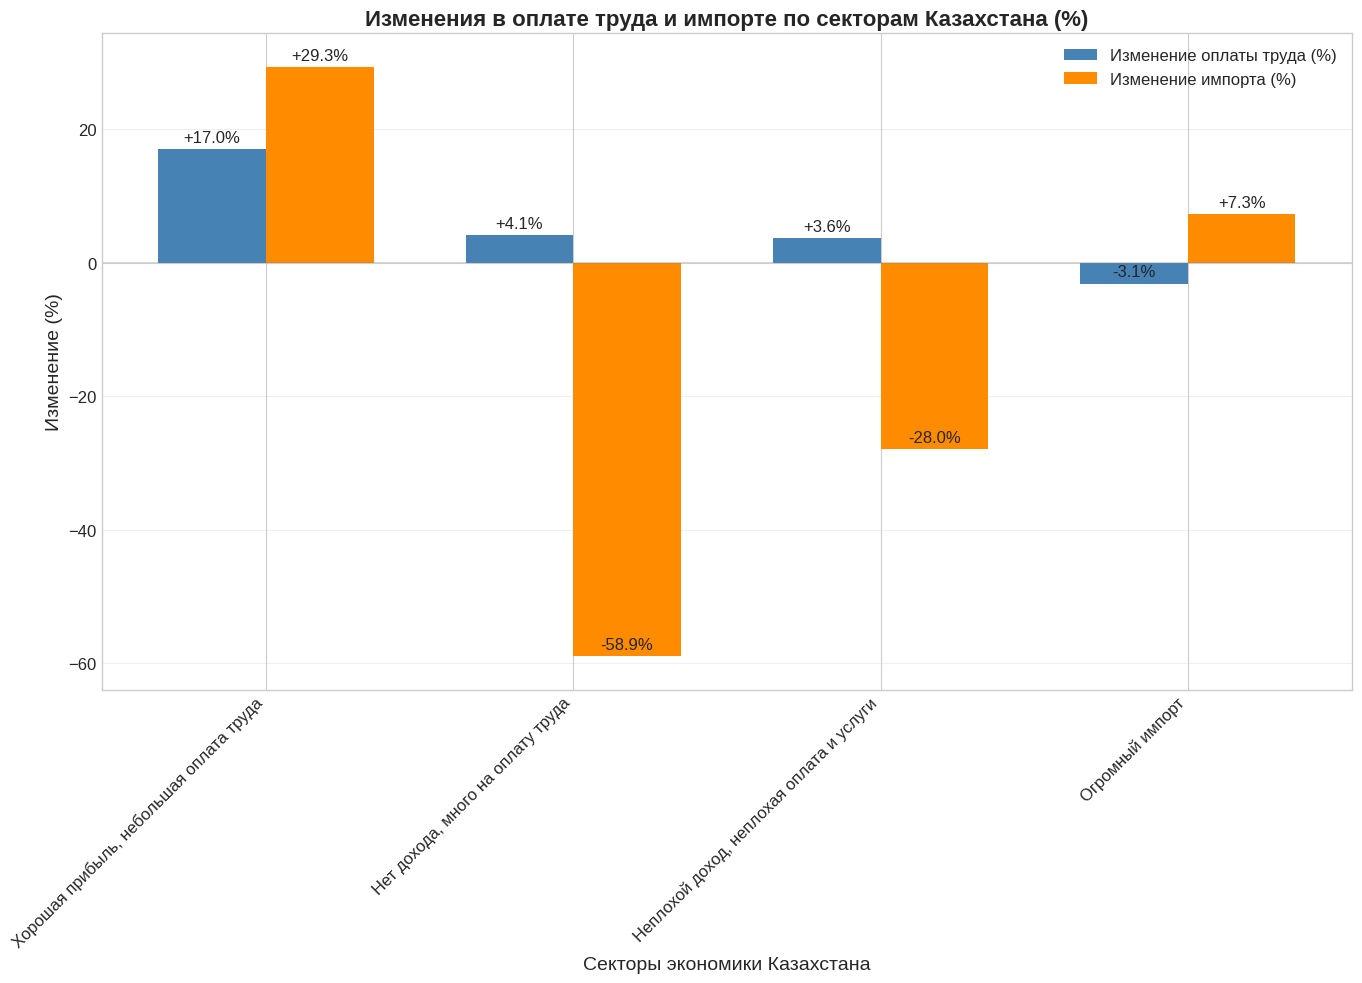

Изменения в оплате труда и импорте (%):
                                     Сектор  Изменение оплаты труда (%)  \
1   Хорошая прибыль, небольшая оплата труда                   17.006326   
2         Нет дохода, много на оплату труда                    4.094512   
0  Неплохой доход, неплохая оплата и услуги                    3.599849   
3                           Огромный импорт                   -3.148388   

   Изменение импорта (%)  
1              29.304694  
2             -58.924687  
0             -27.962000  
3               7.283848  


In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Настройка стиля для графиков
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Загрузка данных из Excel файла
def load_data_from_excel(file_path):
    # Чтение всех листов (годов) из файла
    excel_data = pd.read_excel(file_path, sheet_name=None, header=0)
    years = sorted([int(year) for year in excel_data.keys()])
    
    # Извлечение данных по оплате труда (строка 2) и импорту (строка 6)
    labor_data = {}
    import_data = {}
    
    # Получаем названия секторов из первого листа
    first_sheet = excel_data[str(years[0])]
    sectors = first_sheet.columns.tolist()
    
    # Инициализируем словари для каждого сектора
    for sector in sectors:
        labor_data[sector] = []
        import_data[sector] = []
    
    # Заполняем данные для каждого года
    for year in years:
        sheet = excel_data[str(year)]
        
        # Оплата труда (строка 2, индекс 1)
        labor_row = sheet.iloc[1]
        
        # Импорт (строка 6, индекс 5)
        import_row = sheet.iloc[5]
        
        for sector in sectors:
            labor_data[sector].append(labor_row[sector])
            import_data[sector].append(import_row[sector])
    
    return years, sectors, labor_data, import_data

# Загружаем данные
years, sectors, labor_data, import_data = load_data_from_excel('3quadrant_aggr2_normalized.xlsx')

# Рассчитываем процентные изменения между 2017 и 2023
labor_changes = {}
import_changes = {}

for sector in sectors:
    labor_first = labor_data[sector][0]
    labor_last = labor_data[sector][-1]
    labor_changes[sector] = ((labor_last - labor_first) / labor_first * 100)
    
    import_first = import_data[sector][0]
    import_last = import_data[sector][-1]
    import_changes[sector] = ((import_last - import_first) / import_first * 100)

# Создаем DataFrame для изменений
df_changes = pd.DataFrame({
    'Сектор': sectors,
    'Изменение оплаты труда (%)': [labor_changes[sector] for sector in sectors],
    'Изменение импорта (%)': [import_changes[sector] for sector in sectors]
})

# Сортируем по изменению оплаты труда
df_changes = df_changes.sort_values('Изменение оплаты труда (%)', ascending=False)

# Создаем график изменений
fig, ax = plt.subplots(figsize=(14, 10))

x = np.arange(len(df_changes['Сектор']))
width = 0.35

# Создаем столбцы для оплаты труда и импорта
bars1 = ax.bar(x - width/2, df_changes['Изменение оплаты труда (%)'], width, label='Изменение оплаты труда (%)', color='steelblue')
bars2 = ax.bar(x + width/2, df_changes['Изменение импорта (%)'], width, label='Изменение импорта (%)', color='darkorange')

# Добавляем значения над столбцами
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        sign = "+" if height > 0 else ""
        ax.annotate(f'{sign}{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

# Настройка осей и легенды
ax.set_xlabel('Секторы экономики Казахстана', fontsize=14)
ax.set_ylabel('Изменение (%)', fontsize=14)
ax.set_title('Изменения в оплате труда и импорте по секторам Казахстана (%)', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_changes['Сектор'], rotation=45, ha='right', fontsize=12)
ax.legend(fontsize=12)

# Добавляем горизонтальную линию на нуле
ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

# Добавляем сетку для лучшей читаемости
ax.grid(True, axis='y', alpha=0.3)

# Устанавливаем диапазон оси Y с небольшим запасом
max_val = max(max(df_changes['Изменение оплаты труда (%)']), max(df_changes['Изменение импорта (%)']))
min_val = min(min(df_changes['Изменение оплаты труда (%)']), min(df_changes['Изменение импорта (%)']))
ax.set_ylim([min_val - 5, max_val + 5])

plt.tight_layout()
plt.savefig('labor_import_changes.png', dpi=300, bbox_inches='tight')
plt.show()

# Вывод данных изменений для проверки
print("Изменения в оплате труда и импорте (%):")
print(df_changes)

Ключевые секторы для анализа оплаты труда: ['Хорошая прибыль, небольшая оплата труда', 'Нет дохода, много на оплату труда', 'Неплохой доход, неплохая оплата и услуги', 'Огромный импорт']
Ключевые секторы для анализа импорта: ['Нет дохода, много на оплату труда', 'Хорошая прибыль, небольшая оплата труда', 'Неплохой доход, неплохая оплата и услуги', 'Огромный импорт']


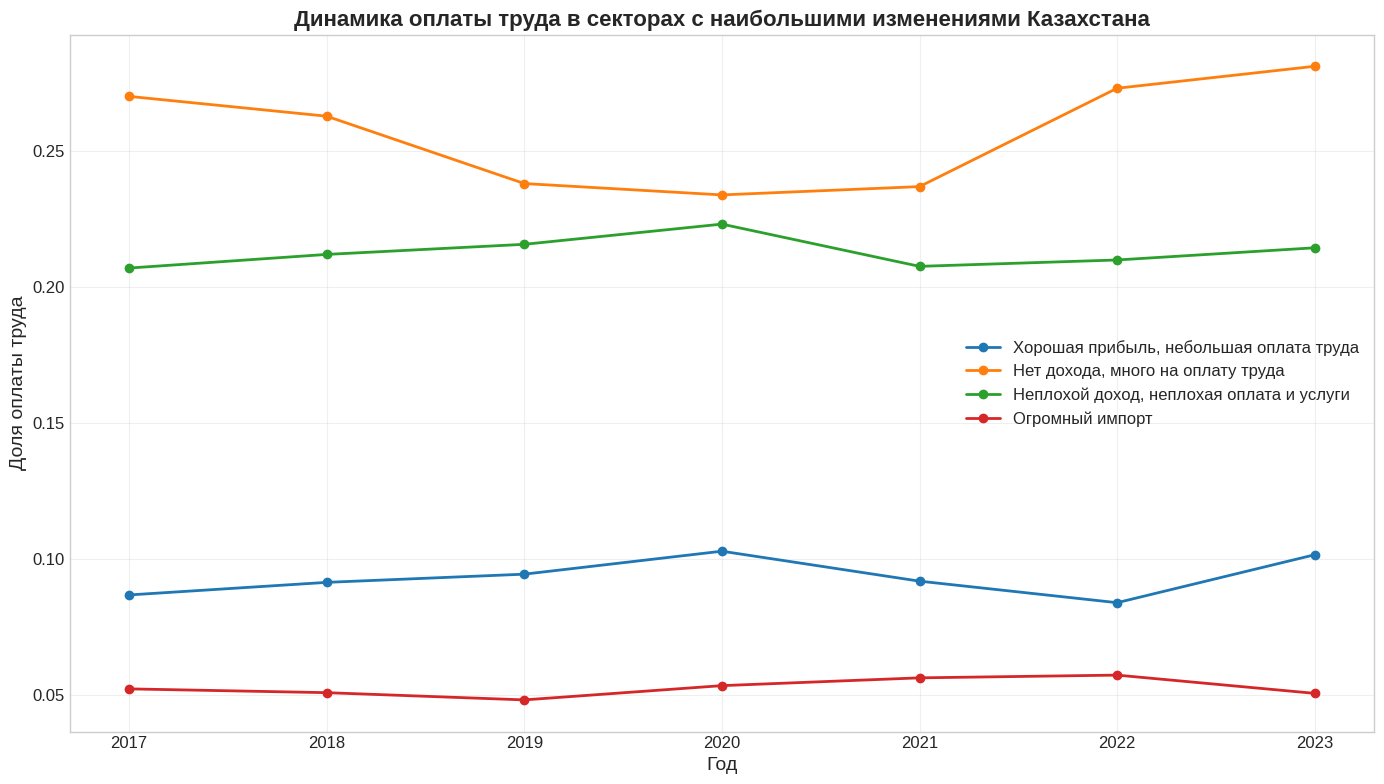

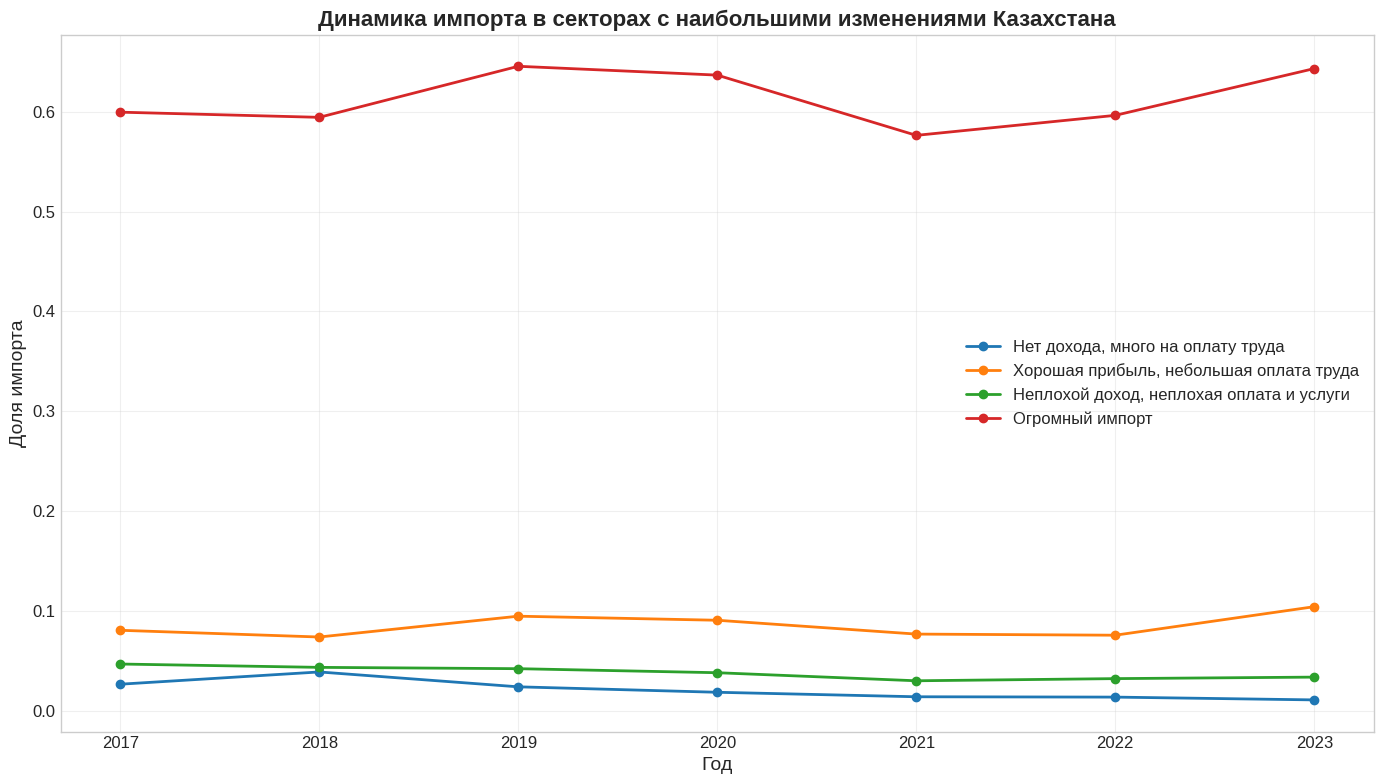

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Настройка стиля для графиков
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Загрузка данных из Excel файла
def load_data_from_excel(file_path):
    # Чтение всех листов (годов) из файла
    excel_data = pd.read_excel(file_path, sheet_name=None, header=0)
    years = sorted([int(year) for year in excel_data.keys()])
    
    # Извлечение данных по оплате труда (строка 2) и импорту (строка 6)
    labor_data = {}
    import_data = {}
    
    # Получаем названия секторов из первого листа
    first_sheet = excel_data[str(years[0])]
    sectors = first_sheet.columns.tolist()
    
    # Инициализируем словари для каждого сектора
    for sector in sectors:
        labor_data[sector] = []
        import_data[sector] = []
    
    # Заполняем данные для каждого года
    for year in years:
        sheet = excel_data[str(year)]
        
        # Оплата труда (строка 2, индекс 1)
        labor_row = sheet.iloc[1]
        
        # Импорт (строка 6, индекс 5)
        import_row = sheet.iloc[5]
        
        for sector in sectors:
            labor_data[sector].append(labor_row[sector])
            import_data[sector].append(import_row[sector])
    
    return years, sectors, labor_data, import_data

# Загружаем данные
years, sectors, labor_data, import_data = load_data_from_excel('3quadrant_aggr2_normalized.xlsx')

# Создаем DataFrame для динамики оплаты труда
df_labor = pd.DataFrame(labor_data, index=years)

# Создаем DataFrame для динамики импорта
df_import = pd.DataFrame(import_data, index=years)

# Выбираем ключевые секторы для анализа оплаты труда
# Определяем их на основе наибольших изменений
labor_changes = {}
for sector in sectors:
    labor_first = labor_data[sector][0]
    labor_last = labor_data[sector][-1]
    labor_changes[sector] = abs((labor_last - labor_first) / labor_first * 100)

# Выбираем 4 сектора с наибольшими изменениями в оплате труда
top_labor_sectors = sorted(labor_changes.items(), key=lambda x: x[1], reverse=True)[:4]
key_labor_sectors = [sector for sector, _ in top_labor_sectors]

# Выбираем ключевые секторы для анализа импорта
import_changes = {}
for sector in sectors:
    import_first = import_data[sector][0]
    import_last = import_data[sector][-1]
    import_changes[sector] = abs((import_last - import_first) / import_first * 100)

# Выбираем 4 сектора с наибольшими изменениями в импорте
top_import_sectors = sorted(import_changes.items(), key=lambda x: x[1], reverse=True)[:4]
key_import_sectors = [sector for sector, _ in top_import_sectors]

print("Ключевые секторы для анализа оплаты труда:", key_labor_sectors)
print("Ключевые секторы для анализа импорта:", key_import_sectors)

# Визуализация динамики оплаты труда в 
plt.figure(figsize=(14, 8))

for sector in key_labor_sectors:
    plt.plot(years, df_labor[sector], marker='o', linewidth=2, label=sector)

plt.title('Динамика оплаты труда в секторах с наибольшими изменениями Казахстана', fontsize=16, fontweight='bold')
plt.xlabel('Год', fontsize=14)
plt.ylabel('Доля оплаты труда', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(years)
plt.tight_layout()
plt.savefig('labor_key_sectors.png', dpi=300, bbox_inches='tight')
plt.show()

# Визуализация динамики импорта в ключевых секторах
plt.figure(figsize=(14, 8))

for sector in key_import_sectors:
    plt.plot(years, df_import[sector], marker='o', linewidth=2, label=sector)

plt.title('Динамика импорта в секторах с наибольшими изменениями Казахстана', fontsize=16, fontweight='bold')
plt.xlabel('Год', fontsize=14)
plt.ylabel('Доля импорта', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(years)
plt.tight_layout()
plt.savefig('import_key_sectors.png', dpi=300, bbox_inches='tight')
plt.show()

Процентное изменение оплаты труда :
Хорошая прибыль, небольшая оплата труда: 17.01%
Нет дохода, много на оплату труда: 4.09%
Неплохой доход, неплохая оплата и услуги: 3.60%
Огромный импорт: -3.15%

Процентное изменение импорта :
Хорошая прибыль, небольшая оплата труда: 29.30%
Огромный импорт: 7.28%
Неплохой доход, неплохая оплата и услуги: -27.96%
Нет дохода, много на оплату труда: -58.92%


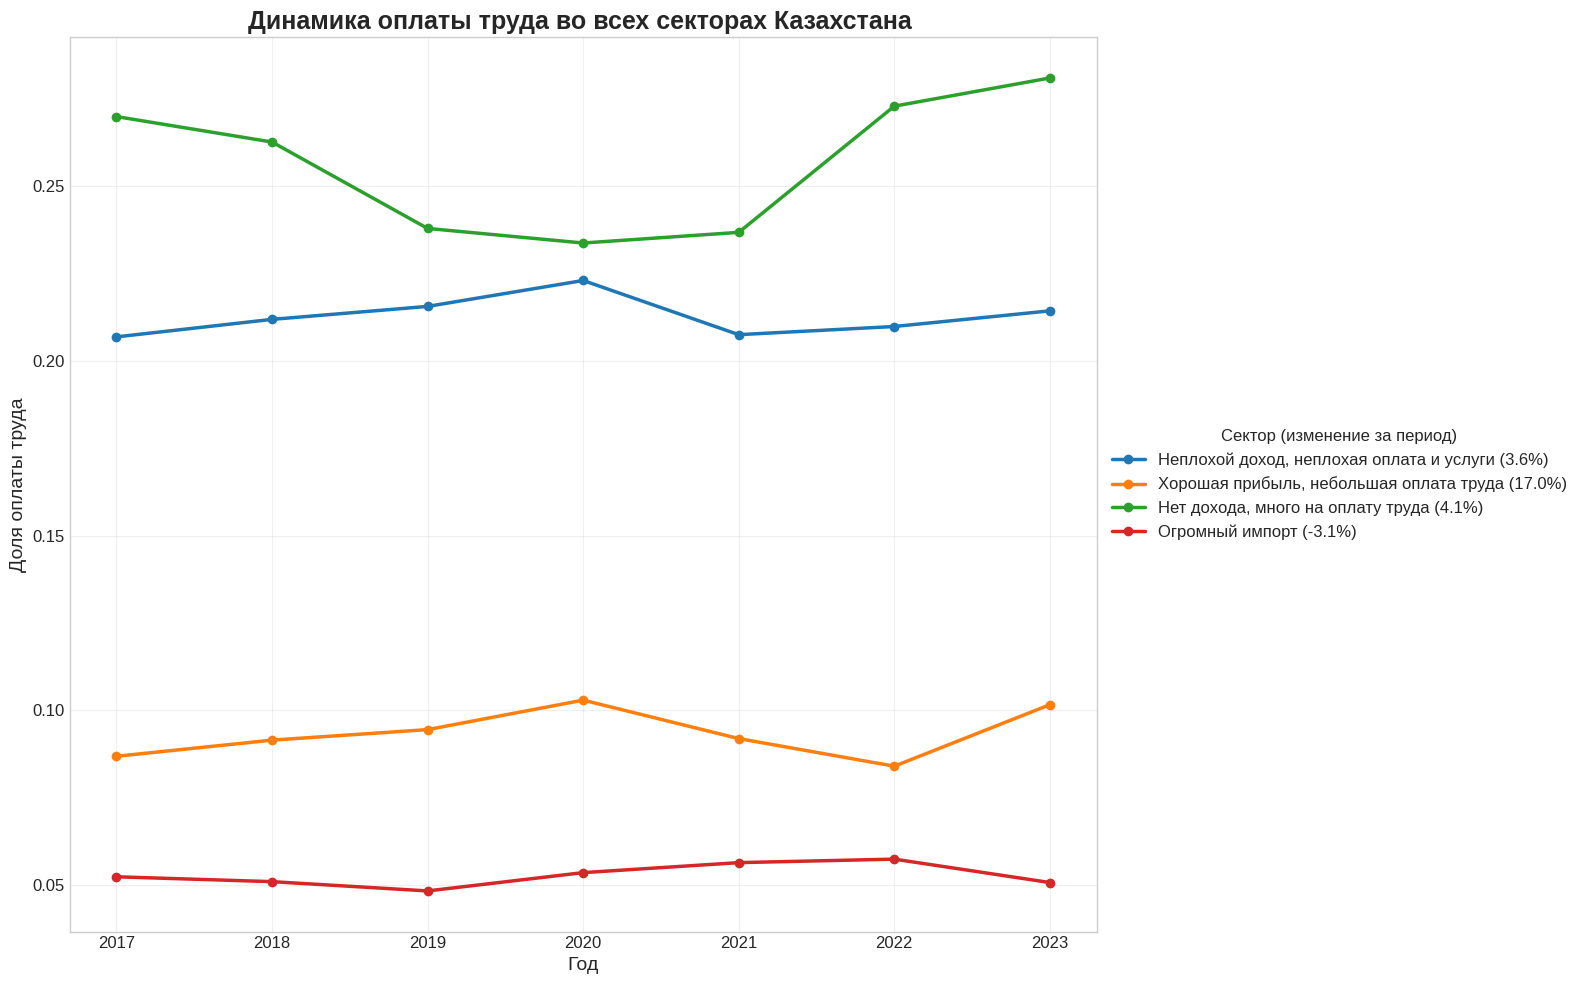

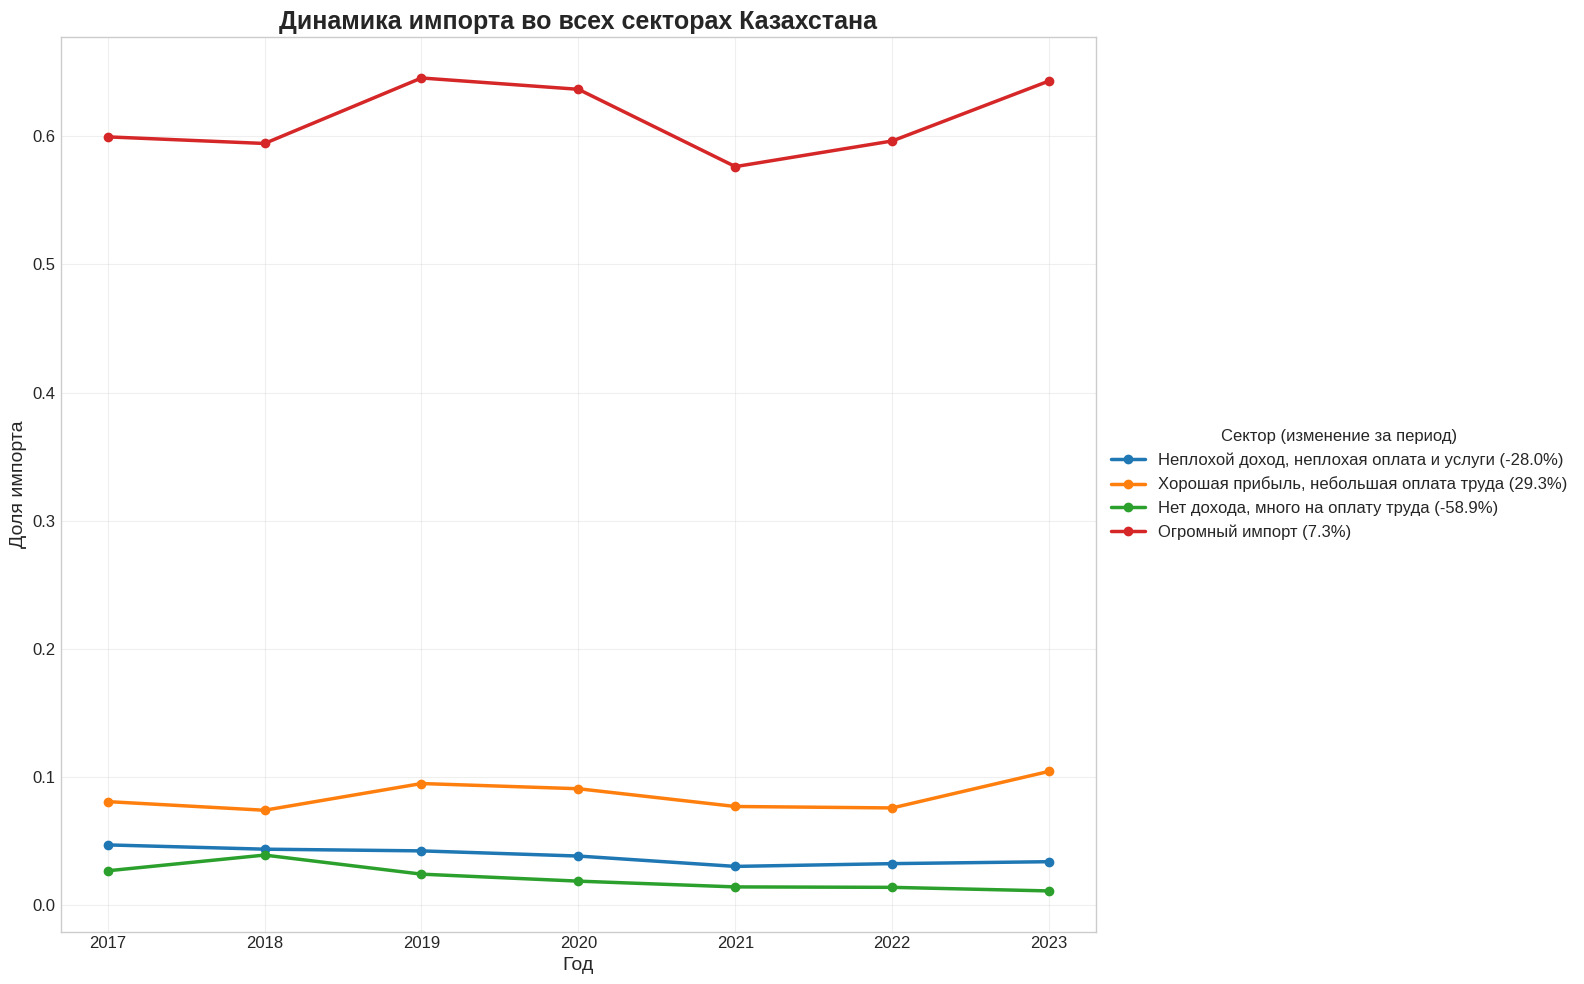

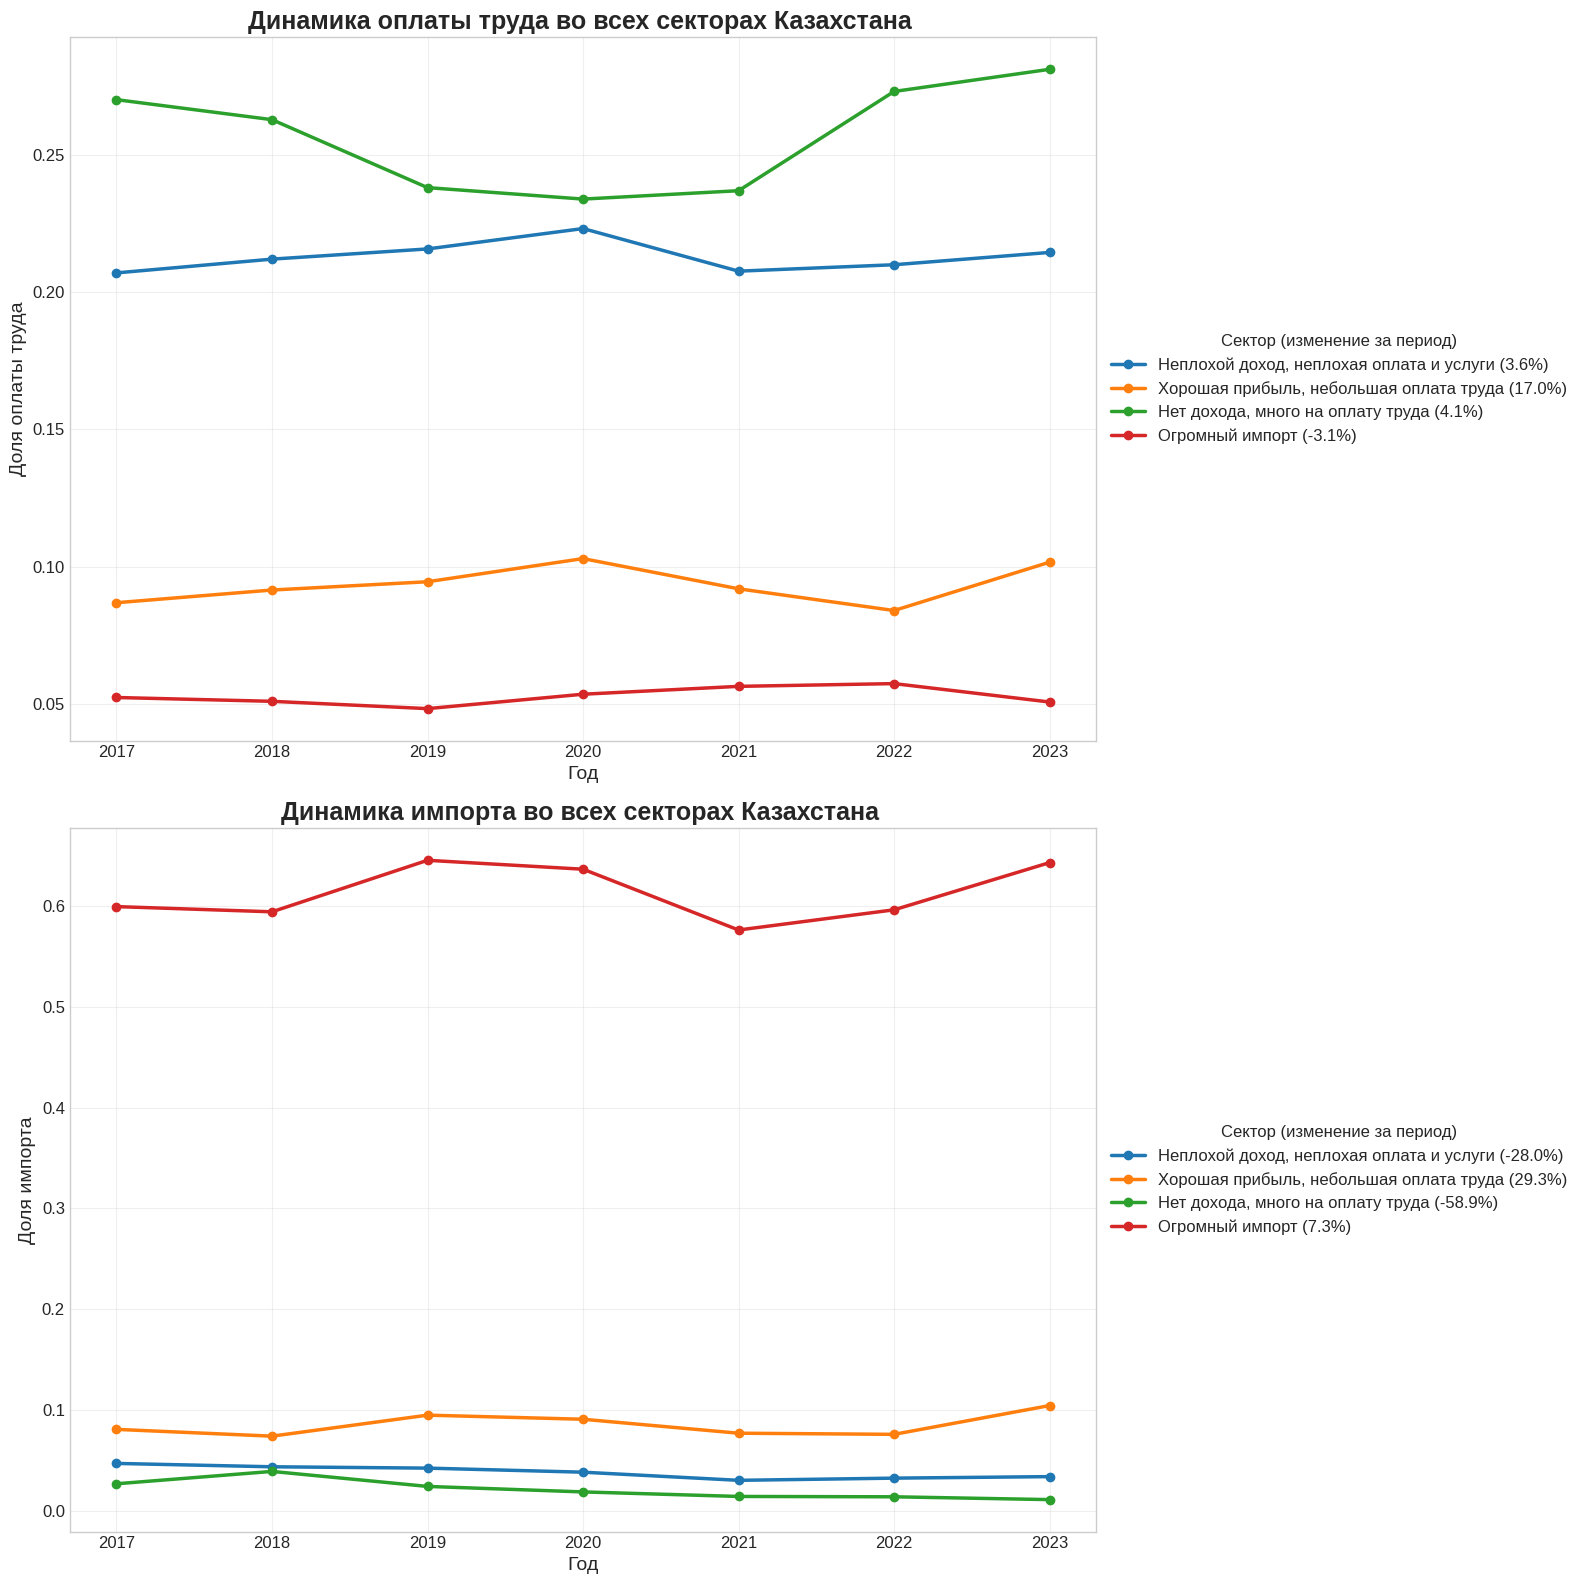

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Настройка стиля для графиков
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 12

# Загрузка данных из Excel файла
def load_data_from_excel(file_path):
    # Чтение всех листов (годов) из файла
    excel_data = pd.read_excel(file_path, sheet_name=None, header=0)
    years = sorted([int(year) for year in excel_data.keys()])
    
    # Извлечение данных по оплате труда (строка 2) и импорту (строка 6)
    labor_data = {}
    import_data = {}
    
    # Получаем названия секторов из первого листа
    first_sheet = excel_data[str(years[0])]
    sectors = first_sheet.columns.tolist()
    
    # Инициализируем словари для каждого сектора
    for sector in sectors:
        labor_data[sector] = []
        import_data[sector] = []
    
    # Заполняем данные для каждого года
    for year in years:
        sheet = excel_data[str(year)]
        
        # Оплата труда (строка 2, индекс 1)
        labor_row = sheet.iloc[1]
        
        # Импорт (строка 6, индекс 5)
        import_row = sheet.iloc[5]
        
        for sector in sectors:
            labor_data[sector].append(labor_row[sector])
            import_data[sector].append(import_row[sector])
    
    return years, sectors, labor_data, import_data

# Загружаем данные
years, sectors, labor_data, import_data = load_data_from_excel('3quadrant_aggr2_normalized.xlsx')

# Создаем DataFrame для динамики оплаты труда
df_labor = pd.DataFrame(labor_data, index=years)

# Создаем DataFrame для динамики импорта
df_import = pd.DataFrame(import_data, index=years)

# Рассчитываем процентные изменения между 2017 и 2023
labor_percent_changes = {}
import_percent_changes = {}

for sector in sectors:
    labor_first = labor_data[sector][0]
    labor_last = labor_data[sector][-1]
    labor_percent_changes[sector] = ((labor_last - labor_first) / labor_first * 100)
    
    import_first = import_data[sector][0]
    import_last = import_data[sector][-1]
    import_percent_changes[sector] = ((import_last - import_first) / import_first * 100)

# Вывод процентных изменений для проверки
print("Процентное изменение оплаты труда :")
for sector, change in sorted(labor_percent_changes.items(), key=lambda x: x[1], reverse=True):
    print(f"{sector}: {change:.2f}%")

print("\nПроцентное изменение импорта :")
for sector, change in sorted(import_percent_changes.items(), key=lambda x: x[1], reverse=True):
    print(f"{sector}: {change:.2f}%")

# Определяем цвета для каждого сектора
colors = plt.cm.tab10.colors

# Визуализация динамики оплаты труда для всех секторов
plt.figure(figsize=(16, 10))
for i, sector in enumerate(sectors):
    plt.plot(years, df_labor[sector], marker='o', linewidth=2.5, 
             label=f"{sector} ({labor_percent_changes[sector]:.1f}%)", color=colors[i % len(colors)])

plt.title('Динамика оплаты труда во всех секторах Казахстана ', 
          fontsize=18, fontweight='bold')
plt.xlabel('Год', fontsize=14)
plt.ylabel('Доля оплаты труда', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5), title="Сектор (изменение за период)")
plt.xticks(years)
plt.tight_layout()
plt.savefig('labor_all_sectors.png', dpi=300, bbox_inches='tight')
plt.show()

# Визуализация динамики импорта для всех секторов
plt.figure(figsize=(16, 10))
for i, sector in enumerate(sectors):
    plt.plot(years, df_import[sector], marker='o', linewidth=2.5, 
             label=f"{sector} ({import_percent_changes[sector]:.1f}%)", color=colors[i % len(colors)])

plt.title('Динамика импорта во всех секторах Казахстана', 
          fontsize=18, fontweight='bold')
plt.xlabel('Год', fontsize=14)
plt.ylabel('Доля импорта', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5), title="Сектор (изменение за период)")
plt.xticks(years)
plt.tight_layout()
plt.savefig('import_all_sectors.png', dpi=300, bbox_inches='tight')
plt.show()

# Дополнительно: создаем субграфики для лучшей читаемости
fig, axs = plt.subplots(2, 1, figsize=(16, 16))

# Оплата труда
for i, sector in enumerate(sectors):
    axs[0].plot(years, df_labor[sector], marker='o', linewidth=2.5, 
             label=f"{sector} ({labor_percent_changes[sector]:.1f}%)", color=colors[i % len(colors)])

axs[0].set_title('Динамика оплаты труда во всех секторах Казахстана ', 
          fontsize=18, fontweight='bold')
axs[0].set_xlabel('Год', fontsize=14)
axs[0].set_ylabel('Доля оплаты труда', fontsize=14)
axs[0].grid(True, alpha=0.3)
axs[0].legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5), title="Сектор (изменение за период)")
axs[0].set_xticks(years)

# Импорт
for i, sector in enumerate(sectors):
    axs[1].plot(years, df_import[sector], marker='o', linewidth=2.5, 
             label=f"{sector} ({import_percent_changes[sector]:.1f}%)", color=colors[i % len(colors)])

axs[1].set_title('Динамика импорта во всех секторах Казахстана ', 
          fontsize=18, fontweight='bold')
axs[1].set_xlabel('Год', fontsize=14)
axs[1].set_ylabel('Доля импорта', fontsize=14)
axs[1].grid(True, alpha=0.3)
axs[1].legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5), title="Сектор (изменение за период)")
axs[1].set_xticks(years)

plt.tight_layout()
plt.savefig('labor_import_all_sectors_subplots.png', dpi=300, bbox_inches='tight')
plt.show()